In [1]:
import argparse
from pathlib import Path

import torch
from torch.utils.data import DataLoader
from tqdm import tqdm

import data_loader.data_loaders as module_data
import model.model as module_arch
from utils.parse_config import ConfigParser
from utils import to, PLYSaver, DS_Wrapper

import torch.nn.functional as F

import matplotlib.pyplot as plt

In [2]:
config_path = "/usr/stud/kaa/thesis/MonoRec/configs/test/pointcloud_monorec_deepscenario.json"

def custom_argparse():
    """Hacky solution to allow for custom command line arguments in a
    Notebook instead of a command-line interface.

    The config is just given as the default argument."""
    parser = argparse.ArgumentParser(description='PyTorch Template')

    parser.add_argument('-r', '--resume', default=None, type=str,
                    help='path to latest checkpoint (default: None)')
    parser.add_argument('-c', '--config', default=config_path, type=str,
                    help='config file path (default: None)')
    parser.add_argument('-d', '--device', default=None, type=str,
                    help='indices of GPUs to enable (default: all)')

    return ConfigParser(parser)


config = custom_argparse()

In [3]:
logger = config.get_logger('test')

output_dir = Path(config.config.get("output_dir", "saved"))
output_dir.mkdir(exist_ok=True, parents=True)
file_name = config.config.get("file_name", "pc.ply")
use_mask = config.config.get("use_mask", True)
roi = config.config.get("roi", None)

max_d = config.config.get("max_d", 30)
min_d = config.config.get("min_d", 3)

start = config.config.get("start", 0)
end = config.config.get("end", -1)

# setup data_loader instances
data_loader = DataLoader(DS_Wrapper(config.initialize('data_set', module_data), start=start, end=end), batch_size=1, shuffle=False, num_workers=8)

# build model architecture
model = config.initialize('arch', module_arch)
logger.info(model)

if config['n_gpu'] > 1:
    model = torch.nn.DataParallel(model)

# prepare model for testing
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
model.eval()

mask_fill = 32

n = data_loader.batch_size

target_image_size = data_loader.dataset.dataset.target_image_size

plysaver = PLYSaver(target_image_size[0], target_image_size[1], min_d=min_d, max_d=max_d, batch_size=n, roi=roi, dropout=.75)
plysaver.to(device)

pose_buffer = []
intrinsics_buffer = []
mask_buffer = []
keyframe_buffer = []
depth_buffer = []

buffer_length = 5
min_hits = 1
key_index = buffer_length // 2


/usr/stud/kaa/miniconda3/envs/monorec/lib/python3.8/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and will be removed in 0.15. Please use keyword parameter(s) instead.
  warnings.warn(
/usr/stud/kaa/miniconda3/envs/monorec/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MonoRecModel(
  (_feature_extractor): ResnetEncoder(
    (encoder): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    

/usr/stud/kaa/miniconda3/envs/monorec/lib/python3.8/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484810403/work/aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [17]:
def show_image(data):
    """Helper function to display images sampled from the dataloader"""
    image = data["keyframe"].squeeze().cpu().permute(1,2,0)
    plt.imshow(image)

def show_output(output):
    """ Helper function to display depth predictions"""
    image = output.squeeze().cpu()
    plt.imshow(image)

def show_whole_trajectory(data_loader):
    pass


Getting the data from the dataloader

In [8]:
with torch.no_grad():
    data, target = data_loader.__iter__().__next__()
    data = to(data, device) # using custom util function


In [9]:
with torch.no_grad():
        # The target is the depth we use as the labels, when creating a pointcloud
        # it is NOT used
        result = model(data)
        if not isinstance(result, dict):
                result = {"result": result[0]}
        output = result["result"]


/usr/stud/kaa/miniconda3/envs/monorec/lib/python3.8/site-packages/torch/nn/functional.py:4215: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/usr/stud/kaa/miniconda3/envs/monorec/lib/python3.8/site-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


### Exploration

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


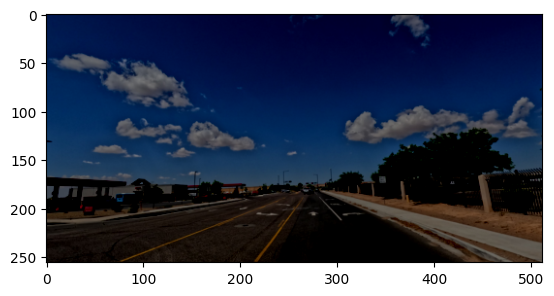

In [22]:
show_image(data)

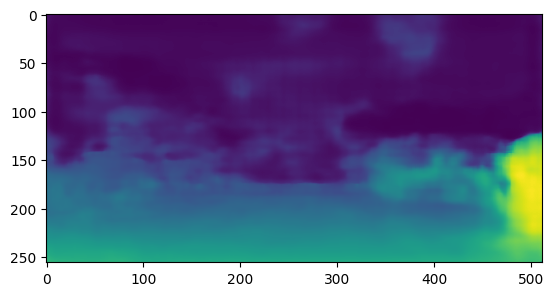

In [21]:
show_output(output)

In [7]:
data

{'keyframe': tensor([[[[-0.0882, -0.0843, -0.0804,  ..., -0.1627, -0.1588, -0.1549],
           [-0.0843, -0.0843, -0.0804,  ..., -0.1588, -0.1549, -0.1588],
           [-0.0843, -0.0804, -0.0765,  ..., -0.1588, -0.1549, -0.1549],
           ...,
           [ 0.0294,  0.0412,  0.0608,  ...,  0.3392,  0.3431,  0.3471],
           [ 0.0333,  0.0529,  0.0451,  ...,  0.3588,  0.3706,  0.3745],
           [ 0.0608,  0.0922,  0.0765,  ...,  0.2647,  0.3314,  0.3706]],
 
          [[ 0.0922,  0.0922,  0.0882,  ..., -0.0020,  0.0020,  0.0059],
           [ 0.0961,  0.0922,  0.0882,  ...,  0.0020,  0.0059,  0.0020],
           [ 0.0961,  0.0961,  0.0922,  ...,  0.0020,  0.0059,  0.0059],
           ...,
           [ 0.0098,  0.0216,  0.0412,  ...,  0.3118,  0.3157,  0.3196],
           [ 0.0137,  0.0333,  0.0255,  ...,  0.3314,  0.3431,  0.3471],
           [ 0.0333,  0.0686,  0.0490,  ...,  0.2059,  0.2882,  0.3392]],
 
          [[ 0.2961,  0.2961,  0.2961,  ...,  0.2020,  0.2059,  0.2098],
 

In [39]:
data, target = data_loader.__iter__().__next__()


In [40]:
data.keys()

dict_keys(['keyframe', 'keyframe_pose', 'keyframe_intrinsics', 'frames', 'poses', 'intrinsics', 'sequence', 'image_id'])

In [44]:
data["poses"]

[tensor([[[ 1.0000e+00, -6.1090e-05,  7.9443e-05,  8.2230e-04],
          [ 6.1097e-05,  1.0000e+00, -9.5694e-05,  2.2418e-03],
          [-7.9437e-05,  9.5699e-05,  1.0000e+00,  1.1615e-02],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]]]),
 tensor([[[ 1.0000e+00, -2.2892e-04,  5.7825e-04,  6.0565e-03],
          [ 2.2865e-04,  1.0000e+00,  4.7307e-04,  1.8473e-02],
          [-5.7836e-04, -4.7294e-04,  1.0000e+00,  9.7633e-02],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]]])]

In [45]:
data["keyframe_pose"]

tensor([[[ 1.0000e+00, -8.4967e-05,  1.0775e-04,  1.2763e-03],
         [ 8.4988e-05,  1.0000e+00, -1.9309e-04,  3.4029e-03],
         [-1.0774e-04,  1.9310e-04,  1.0000e+00,  1.7338e-02],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]]])

In [43]:
data["image_id"]

tensor([[1]], dtype=torch.int32)